# Time Molecule with dissipation

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [3]:
from scipy import *
from scipy.constants import e, h, hbar
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
import random
import scipy.linalg as la
from scipy.linalg import expm, sinm, cosm
import pandas
import numpy
from tqdm import tqdm, tnrange, tqdm_notebook
from ipypb import irange
from ipypb import track
from time import sleep

In [4]:
from ipywidgets import IntProgress         # This is a progress bar, it is optional.
from IPython.display import display
import time

In [5]:
font = {"size":15}
matplotlib.rc("font", **font)

In [6]:
def PauliMatrix (n):                             # Pauli Matrices
    if n == 0:
        return  [[1, 0], [0, 1]]
    if n == 1:
        return  [[0, 1], [1, 0]]
    if n == 2:
        return  [[0, -1j], [1j, 0]]
    if n == 3:
        return  [[1, 0], [0, -1]]
    if n == 4:
        return  [[1, 0], [0, 1]]
    return print ('WRONG Pauli Matrix ID')

A set of functions for calculating Time Molecule without dissipation

In [7]:
def tensorize1SiteMatrixKroneker(nSites, nSite, nPauli):        
    A = zeros(nSites - nSite) 
    B = zeros(nSite - 1)
    C = []
    for i in B:
        C.append(int(i))
    C.append(nPauli)
    for i in A:
        C.append(int(i)) 
    D = []    
    for i in C:
        D.append(PauliMatrix(i))   
    D1=D[0]
    for i in range(1, nSites,1):
        D1=kron(D1,D[i])
    return D1

def fixedLineKK(nSites, k):
    E = []
    for i in range(0, nSites - 1,1):
        E.append(np.dot(tensorize1SiteMatrixKroneker(nSites, i+1, k),tensorize1SiteMatrixKroneker(nSites, i+2, k)))
    return E

def fixedLocalK(nSites, k):
    F = []
    for i in range(0, nSites,1):
        F.append(tensorize1SiteMatrixKroneker(nSites, i+1, k))
    return F
def disorderedLocalK(nSites, k):
    G = []
    for i in range(0, nSites,1):
        G.append(random.random()*tensorize1SiteMatrixKroneker(nSites, i+1, k))
    return G

def deltaS (w, sitesN):                      # The function produces a uniform spread of spin frequencies (disorder)
    H = []
    H.append(0)
    for i in range(1, sitesN,1):
        H.append(i*w/(sitesN-1))
    return H

def states(phiInitFull, Time):               # Calculation of the evolution of the state of the system
    A = np.array([phiInitFull])
    for i in range(0, Time-1,1):
        A = np.append(A, [np.dot(U,A[i])], 0)
    return A

In [8]:
def density_Matrix(phiInitFull):            # The function returns a density matrix over state vectors
    return np.kron(phiInitFull, conjugate(phiInitFull)).reshape(size(phiInitFull),size(phiInitFull))

In [9]:
def Partial_Entropy_2(RHO):                 # Function for calculating the partial entropy of the density matrix for two spins.
    Reduced_matrix = [[RHO[0][0]+RHO[1][1], RHO[0][2]+RHO[1][3]], [RHO[2][0]+RHO[3][1], RHO[2][2]+RHO[3][3]]]
    #print(Reduced_matrix)
    eigvals, eigvecs = la.eig(Reduced_matrix)
    eigvals = real(eigvals)
    nzvals = eigvals[eigvals != 0]
    #print(nzvals)
    logvals = []
    for i in nzvals:
        #print(i)
        logvals.append(log(sqrt(i**2)))
    #print(logvals)
    T = float(real(-sum(nzvals * logvals)))
    return T

In [10]:
def Floquet_eigenvalues(U):                 # Floquet eigenvalue function
    evals, evecs = la.eig(U)
    eargs = angle(evals)

    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    kets_order = [np.matrix(evecs[:, o]).T for o in order]

    return kets_order, e_quasi[order]

In [11]:
def chop(expr, *, max=0.01):    # A strange function that removes unnecessary decimal numbers
    return [np.round(i,3) if abs(i) > max else 0 for i in expr]

def matrix_chop(matrix):        # Also for the matrix
    T = []
    for i in matrix:
        T.append(chop(i))
    return T

Functions for the Lindbladian Time Molecule

In [12]:
def identity_matrix(demention):                 
    I = np.zeros((demention,demention), dtype=float)
    for i in arange(0,demention):
        I[i][i]=1
    return I

def sigma_minus():
    return [[0,0],[1,0]]
def sigma_plus():
    return [[0,1],[0,0]]

just in case of periodic boundary conditions, so if there is a $\sum_{i = (1 .. nSpins)}$, for2 - spin operators, the last one will be periodic : from the first to the last spin

In [13]:
def iFunc(n,x):
    if (x <= n):
        return x
    else:
        return x-n

*Turning local operators into global ("tensorized") operators of a many - body system. $m_1$, $m_2$ -- local operators, $i_1$, $i_2$ -- locations of the corresponding spins*

In [14]:
def twoSiteOpearatorTensorization(matrix1, matrix2, i1, i2, nSites):
    T = []
    for i in arange(nSites):
        if (i == iFunc(nSites,i1)-1):
            T.append(matrix1)
        if (i == iFunc(nSites,i2)-1):
            T.append(matrix2)
        if ((i!=iFunc(nSites,i1)-1)&(i!=iFunc(nSites,i2)-1)):
            T.append(PauliMatrix(0))
                   
    mat = kron(T[0],T[1])
    for i in arange(nSites-2):
        mat = kron(mat,T[i])
    return mat

def oneSiteOpearatorTensorization(matrix, i, nSites):
    return twoSiteOpearatorTensorization(matrix, identity_matrix(2),i,i+1,nSites) 

Lindbladization of hamiltonian and dissipation operators

In [15]:
def hamiltonianToLindblad(h):
    return -1j*(-kron(np.matrix(h).T,identity_matrix(int(np.sqrt(size(h)))))+kron(identity_matrix(int(np.sqrt(size(h)))),np.matrix(h)))

In [16]:
def jumpOperatorToLindblad(a):
    n = int(np.sqrt(size(a)))
    return kron(conj(a),a)-0.5*(kron(identity_matrix(n),dot(conj(a).T,a))+kron(dot(conj(a).T,a).T,identity_matrix(n)))

vectorization of the density matrix and reverse

In [17]:
def flatDensityMatrixToFull(m):
    return m.reshape(int(np.sqrt(size(m))), int(np.sqrt(size(m)))).T
def fullDensityMatrixToflat(m):
    return m.T.reshape(-1, 1)

In [18]:
def matrix_chop(matrix):
    T = []
    for i in matrix:
        T.append(chop(i))
    return T

def chop(expr, *, max=0.01):
    return [np.round(i,3) if abs(i) > max else 0 for i in expr]

In [19]:
def real_imagination(matrix):
    new_re = np.zeros((size(matrix[0]),size(matrix[0])), dtype=float)
    new_im = np.zeros((size(matrix[0]),size(matrix[0])), dtype=float)
    full = np.zeros((size(matrix[0]),size(matrix[0])), dtype=np.complex)
    for i in arange(size(matrix[0])):
        for j in arange(size(matrix[0])):
            new_re[i][j] = matrix[i][j].real
            new_im[i][j] = matrix[i][j].imag
            full[i][j] = matrix[i][j].real+matrix[i][j].imag*1j
    return new_re, new_im, full  

Concurrence function

In [20]:
def concurrence(RHO):
    rhot = np.dot(np.dot(kron(PauliMatrix(2),PauliMatrix(2)), conj(RHO)),kron(PauliMatrix(2),PauliMatrix(2)))
    eigs = la.fractional_matrix_power(np.dot(np.dot(la.fractional_matrix_power(RHO, 1/2),rhot),la.fractional_matrix_power(RHO, 1/2)),1/2)
    evals, evecs = la.eig(eigs) 
    #evals = chop(sort(evals))
    evals = sort(evals)
    return (max(0,evals[3]-evals[2]-evals[1]-evals[0]))

Interaction and evolution

In [21]:
def Ufunc_all_to_all(nSites,alpha,g,T,delta):      # Function U specifying the evolution of a system without dissipation
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1))            #interaction
    for i in range(1, nSites+1,1):
        for j in range(1,nSites+1,1):
            if i<j:
                #print(i,j)
                xxyy = xxyy + np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, j, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, j, 2))
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 

def Ufunc_all_to_all_lind(nSites,alpha,g,T,delta,disOps):  # Function U specifying the evolution of a system with dissipation
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1))            #interaction
    for i in range(1, nSites+1,1):
        for j in range(1,nSites+1,1):
            if i<j:
                #print(i,j)
                xxyy = xxyy + np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, j, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, j, 2))
                    
    Xlindbladian=hamiltonianToLindblad(X)
    Zlindbladian=hamiltonianToLindblad(Z)
    xxyylindbladian=hamiltonianToLindblad(xxyy)
    
                    
    collapse = np.zeros((nSites**4,nSites**4), dtype=float)
    for i in arange(3*nSites): 
        collapse  = collapse  + jumpOperatorToLindblad(disOps[i])
    
    return np.dot(expm(alpha*Xlindbladian),expm((T*(Zlindbladian+g*xxyylindbladian+collapse))))
    
def states_lind(phiInitFull, func, Time):   # evolution of the system with dissipation
    A = np.array([phiInitFull])
    for i in range(0, Time-1,1):
        A = np.append(A, [np.dot(func,A[i])], 0)
    return A

In [22]:
def Piecewisese(Matrix):
    New = np.zeros((eps_steps,g_steps), dtype=float)
    for g_id, g_value in enumerate(g): 
        for alpha_id, alpha_value in enumerate(alpha): 
            if Matrix[alpha_id][g_id]>Matrix[alpha_id-1][g_id]:
                New[alpha_id][g_id] = 1
            if Matrix[alpha_id][g_id]<Matrix[alpha_id-1][g_id]:
                New[alpha_id][g_id] = -1
            if abs(Matrix[alpha_id][g_id]-Matrix[alpha_id-1][g_id])<10e-4:
                New[alpha_id][g_id] = 0
    return New     

In [23]:
def complex_plane2(z,axis_type=0, fig=None, ax=None):
    
    w=max(np.abs(z))
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
        
    plt.cla() 
    plt.clf() 
    
    if axis_type==0: 
        plt.axis("off")
        plt.text(-0.15*w, 0.8*w, "Im", fontsize=14)
        plt.text( 0.8*w,-0.15*w, "Re", fontsize=14)
    elif axis_type==1: 
        plt.axis("on")
        plt.grid()
        plt.text(-0.15*w, 0.8*w, "Im", fontsize=14)
        plt.text( 0.8*w,-0.15*w, "Re", fontsize=14)
    else:
         # Move left y-axis and bottom x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        ax.set_xlabel('                                                 Re []')
        ax.set_ylabel('                                                 Im []')

    plt.xlim(-w,w)
    plt.ylim(-w,w)
    plt.arrow(0, -w, 0, 1.9*w, head_width=w/20, head_length=w/20, fc='b', ec='b');
    plt.arrow(-w, 0, 1.9*w, 0, head_width=w/20, head_length=w/20, fc='b', ec='b');
    
    colors = ['#00FFFF','#000000','#0000FF','#FF00FF','#808080','#008000','#00FF00','#800000','#000080','#808000','#800080','#FF0000','#C0C0C0','#008080','#F00f0F','#FFFF00']

    for i in range(len(z)):
        fi_a=np.angle(z[i])
        x=z[i].real -abs(w)/20*np.cos(fi_a)
        y=z[i].imag-abs(w)/20*np.sin(fi_a)
        plt.arrow(0, 0, x, y, head_width=w/20, head_length=w/20, fc=colors[i], ec=colors[i]);
        
    return fig, ax

Animation

In [24]:
from IPython.display import HTML
from matplotlib import animation

#We need this for codec and visualization of time dynamics

from base64 import b64encode

def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
    return HTML(video_tag)


In [25]:
plt.rcParams['animation.ffmpeg_path'] ='C:\\ffmpeg\\bin\\ffmpeg.exe'  # path to codec location
mywriter = animation.FFMpegWriter()

# Variable Parameters  - eps

Let's draw the evolution of a 2-spin system prepared to create a Time molecule with dissipation.

In [62]:
nSites = 2 

eps_steps = 1500
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses
eps=np.linspace(0.00, 1, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = [0,0]
g = 0.05                             #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [63]:
g1 = 0.01        # relaxation rate
g2 = 0.0025        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

values are found as $Tr(j\rho(t))$

In [64]:
Observables = np.zeros((eps_steps,time_steps), dtype=float)
RHO = np.zeros((eps_steps,time_steps,2**nSites,2**nSites), dtype=list)
Concur = np.zeros((eps_steps,time_steps), dtype=float)
#Vectorrs2 = np.zeros((eps_steps,time_steps), dtype=float)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))


    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states
    
    rho_s = []
    conccc = []
    Temp = []
    for i in arange(time_steps):
        Temp.append(flatDensityMatrixToFull(Final[i]))
        rho_s.append(flatDensityMatrixToFull(Final[i]))
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))
    Final = Temp

    observables = []
    #vectorrs = [] 
      
    for i in Final:
        observables.append(np.dot(sigZOp,i).trace())
        #vectorrs.append(Partial_Entropy_2(flatDensityMatrixToFull(i)))
    
    f.value += 1
    Observables[alpha_id] = observables 
    RHO[alpha_id] = rho_s
    Concur[alpha_id] = conccc
    #Vectorrs2[alpha_id] = vectorrs

IntProgress(value=0, max=1500)

<ipython-input-64-547d6555e0e8>:41: ComplexWarning: Casting complex values to real discards the imaginary part
  Observables[alpha_id] = observables
<ipython-input-64-547d6555e0e8>:43: ComplexWarning: Casting complex values to real discards the imaginary part
  Concur[alpha_id] = conccc


In [106]:
plt.rcParams["text.usetex"] = False

In [96]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [103]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

Text(125, 0.185, '(b)')

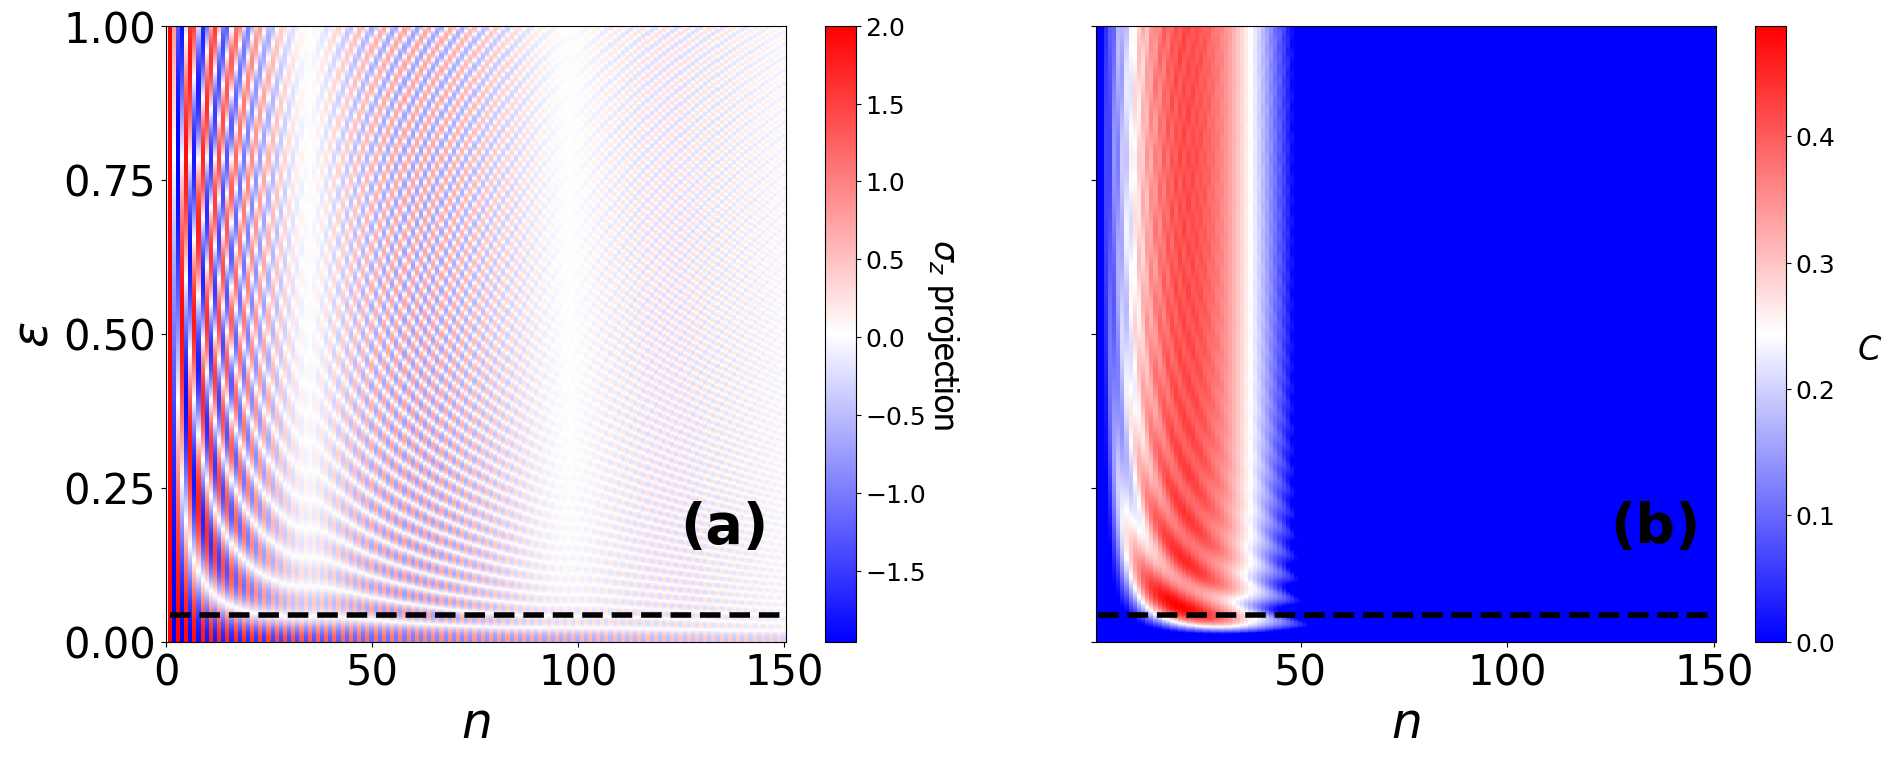

In [65]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,2,figsize=(22, 8))

#plt.rcParams["text.usetex"] = True

p = axes[0].pcolor(times, eps, Observables, cmap=cm.bwr, shading='nearest')

axes[0].axis('tight')
axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=35, **hfont, rotation=90)


axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18) 

#cb.remove()

ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------

#p = axes[1].pcolor(times, eps, Vectorrs2, cmap=cm.Reds)
p = axes[1].pcolor(times, eps, Concur, cmap=cm.bwr, shading='nearest')

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

axes[1].set_yticklabels([])

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[1].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

#axes[1].set_xlim((0.4, 0.6))

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$C$', labelpad=25, rotation=0, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

#cb.remove()

ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------
#p = axes[2].pcolor(times, eps, Concur, cmap=cm.bwr, shading='nearest')

#axes[2].axis('tight')
#axes[2].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[2].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

#axes[2].tick_params(axis='x', labelsize=30)
#axes[2].tick_params(axis='y', labelsize=30)

#axes[2].set_yticklabels([])
#cb = fig.colorbar(p, ax=axes[2])
#cb.set_label(r'$C$', labelpad=35, rotation=0, fontsize=35, **hfont)
#cb.ax.tick_params(labelsize=30)

#ymin, ymax = axes[2].get_ylim()
#axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

#xmin, xmax = axes[2].get_xlim()
#axes[2].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------

axes[0].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
axes[1].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
#axes[2].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)


matplotlib.pyplot.text(-100, 0.185, '(a)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text(125, 0.185, '(b)', fontsize=40, weight="black",  verticalalignment='center')
#matplotlib.pyplot.text( 130, 0.185, '(c)', fontsize=40, weight="black",  verticalalignment='center')

#plt.gcf().set_size_inches(33,8)
#plt.savefig("C:/Users/Kirill Shulga/Desktop/Fig1.png", bbox_inches="tight")

$t_{eq}$ ~~~ $g\cdot T~~$($\pi$ units)

$\varepsilon$  $n$  $C$  $\langle \sigma_z \rangle$

(0.0, 150.0)

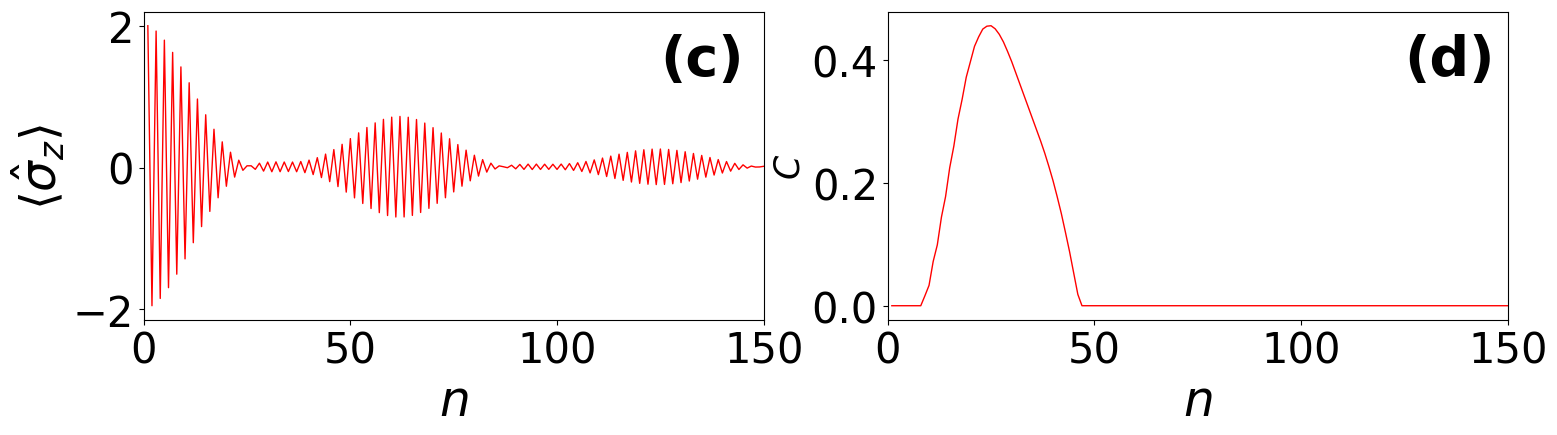

In [38]:
number =   109     #244

hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,2,figsize=(17.6, 4))

#plt.rcParams["text.usetex"] =True

p = axes[0].plot(times, Observables[number], 'r', linewidth=1.0)

axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\langle \hat{\sigma}_z \rangle$', fontsize=35, rotation=90, **hfont)

axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)


#p = axes[1].plot(times, Vectorrs2[number], 'r', linewidth=1.0)
p = axes[1].plot(times, Concur[number], 'r', linewidth=1.0)

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[1].set_ylabel(r'$C$', fontsize=25, **hfont)

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

#p = axes[2].plot(times, Concur[number], 'r', linewidth=1.0)

#axes[2].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[2].set_ylabel(r'$С$', fontsize=25, **hfont)

#axes[2].tick_params(axis='x', labelsize=30)
#axes[2].tick_params(axis='y', labelsize=30)

matplotlib.pyplot.text(-55, 0.4, '(c)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( 125, 0.4, '(d)', fontsize=40, weight="black",  verticalalignment='center')
#matplotlib.pyplot.text( 130, 0.4, '(f)', fontsize=40, weight="black",  verticalalignment='center')

axes[0].set_xticks(np.round(np.linspace(0, 150, 4), 2))
axes[0].set_xlim(0.0,150)
axes[1].set_xlim(0.0,150)
#axes[2].set_xlim(0.0,150)

#plt.gcf().set_size_inches(26.5, 4)
#plt.savefig("C:/Users/Kirill Shulga/Desktop/Time-Molecule/TM_Pic1def.pdf", bbox_inches="tight")

#axes[1].set_xlim((0.475, 0.525))

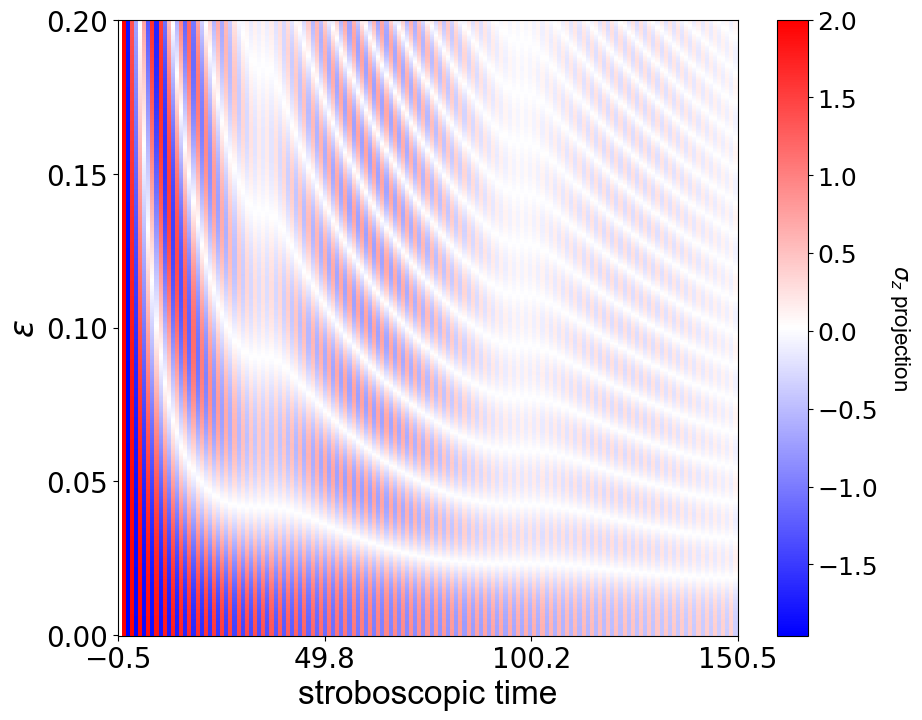

In [73]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 8))


p = axes.pcolor(times, eps, Observables, cmap=cm.bwr)

axes.axis('tight')
axes.set_xlabel(r'stroboscopic time', fontsize=24, **hfont)
axes.set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=16, **hfont)
cb.ax.tick_params(labelsize=18) 
    
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

a crosssection of the previous figure

Text(0, 0.5, '$\\sum\\sigma_z$  Projection')

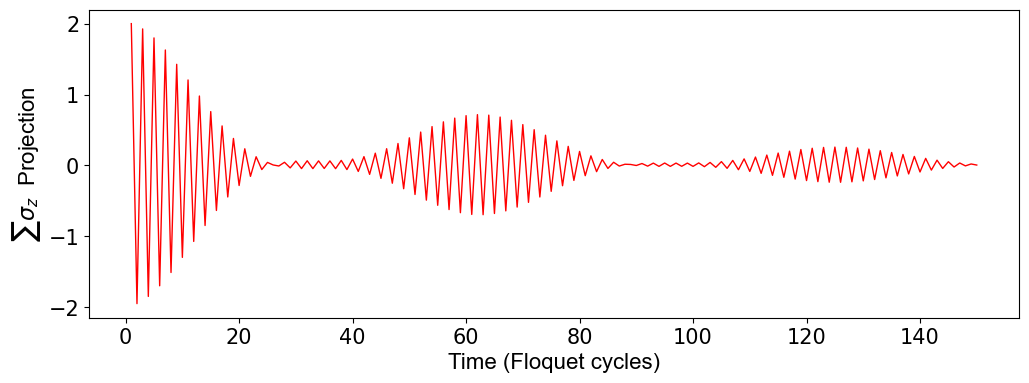

In [33]:
number =   108    #109

hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(12, 4))

p = axes.plot(times, Observables[number], 'r', linewidth=1.0)

axes.set_xlabel(r'Time (Floquet cycles)', fontsize=16, **hfont)
axes.set_ylabel(r'$\sum\sigma_z$  Projection', fontsize=16, **hfont)

In [99]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 8))


p = axes.pcolor(times, eps, Concur, cmap=cm.bwr, shading='auto')

axes.axis('tight')
axes.set_xlabel(r'stroboscopic time', fontsize=24, **hfont)
axes.set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=16, **hfont)
cb.ax.tick_params(labelsize=18) 
    
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

# Variable Parameters - g_1

In [40]:
nSites = 2 

eps_steps = 500
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                     #disorder
delta = [0,0]
g = 0.05                                     #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [41]:
g1 = 0.001        # relaxation rate
g2 = 0.00025        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [42]:
Concur_1 = np.zeros((eps_steps,time_steps), dtype=float)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))

    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states

    conccc = []

    for i in arange(time_steps):
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))

    f.value += 1
    Concur_1[alpha_id] = conccc

IntProgress(value=0, max=500)

<ipython-input-42-dd1917f58edc>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  Concur_1[alpha_id] = conccc


In [43]:
g1 = 0.005        # relaxation rate
g2 = 0.00125        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [44]:
Concur_2 = np.zeros((eps_steps,time_steps), dtype=float)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))

    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states

    conccc = []

    for i in arange(time_steps):
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))

    f.value += 1
    Concur_2[alpha_id] = conccc

IntProgress(value=0, max=500)

<ipython-input-44-e8f93c654bd4>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  Concur_2[alpha_id] = conccc


In [45]:
g1 = 0.01        # relaxation rate
g2 = 0.0025        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [46]:
Concur_3 = np.zeros((eps_steps,time_steps), dtype=float)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))

    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states

    conccc = []

    for i in arange(time_steps):
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))

    f.value += 1
    Concur_3[alpha_id] = conccc

IntProgress(value=0, max=500)

<ipython-input-46-f992c8e186e5>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  Concur_3[alpha_id] = conccc


Text(125, 0.185, '(c)')

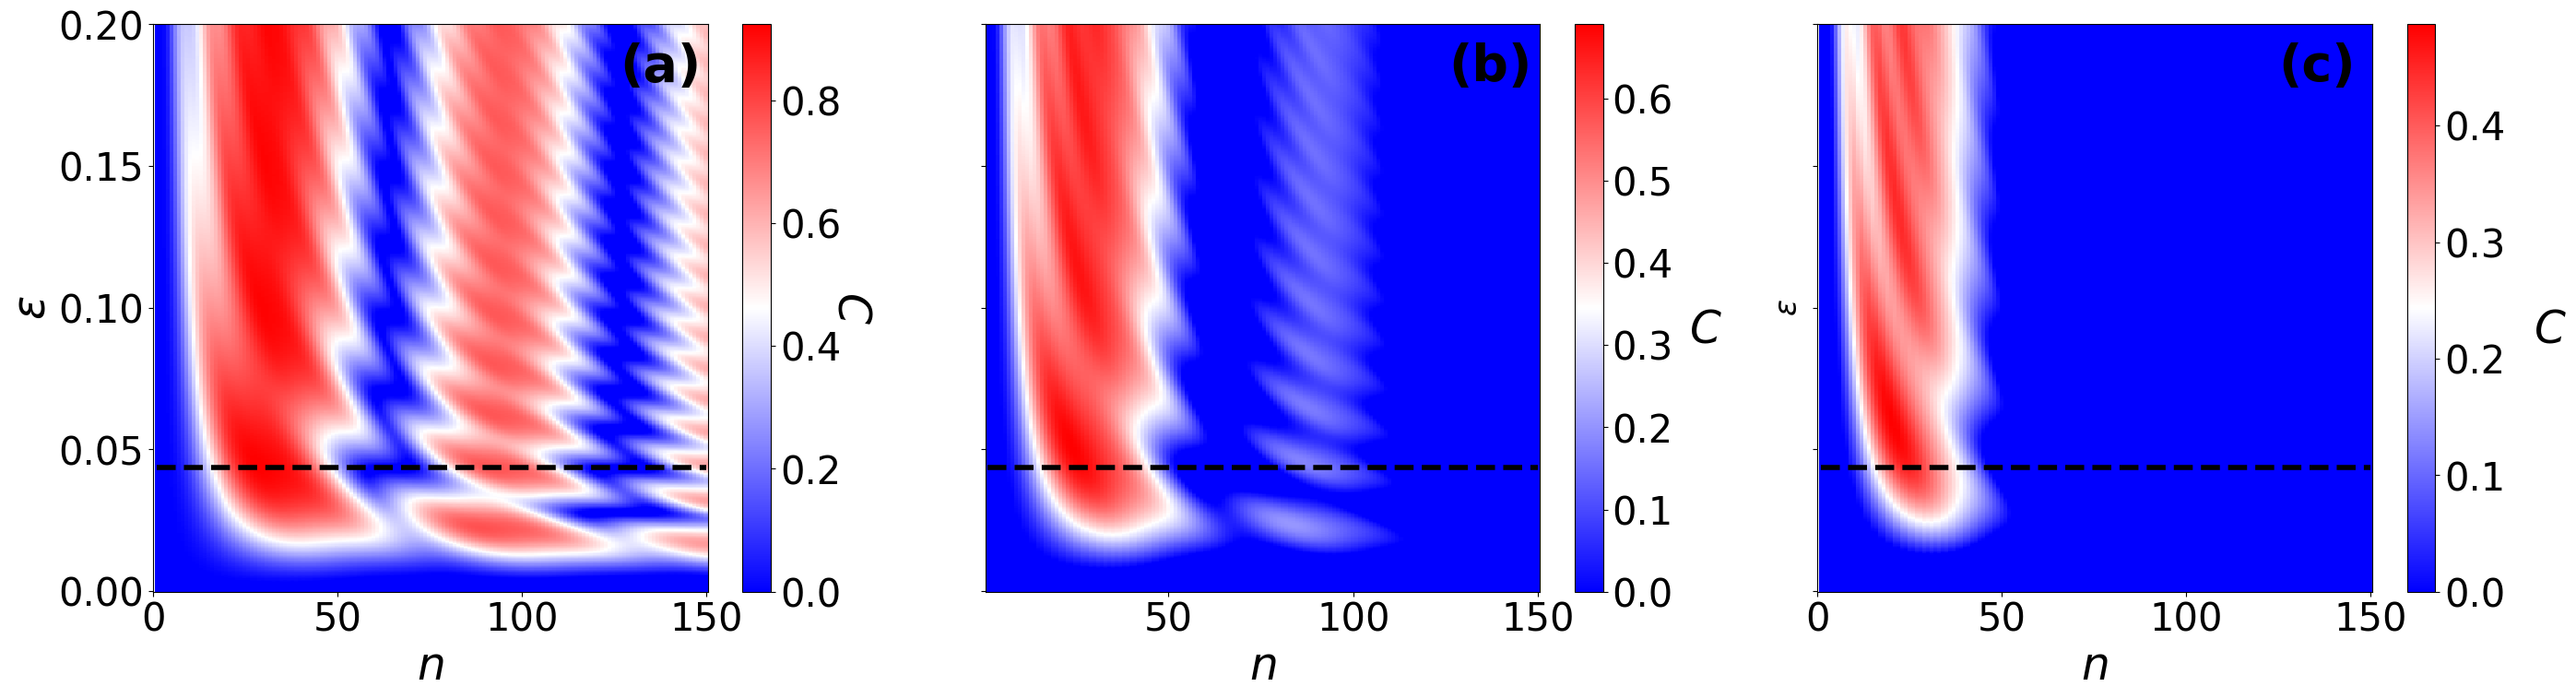

In [60]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,3,figsize=(33, 8))

#plt.rcParams["text.usetex"] = True

p = axes[0].pcolor(times, eps, Concur_1, cmap=cm.bwr, shading='nearest')

axes[0].axis('tight')
axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=35, **hfont, rotation=90)


axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$C$', labelpad=25, rotation=270, fontsize=35, **hfont)
cb.ax.tick_params(labelsize=30) 

#cb.remove()

ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------

p = axes[1].pcolor(times, eps, Concur_2, cmap=cm.bwr, shading='nearest')

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

axes[1].set_yticklabels([])

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[1].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

#axes[1].set_xlim((0.4, 0.6))

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$C$', labelpad=25, rotation=0, fontsize=35, **hfont)
cb.ax.tick_params(labelsize=30)

#cb.remove()

ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------
p = axes[2].pcolor(times, eps, Concur_3, cmap=cm.bwr, shading='nearest')

axes[2].axis('tight')
axes[2].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[2].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

axes[2].tick_params(axis='x', labelsize=30)
axes[2].tick_params(axis='y', labelsize=30)

axes[2].set_yticklabels([])
cb = fig.colorbar(p, ax=axes[2])
cb.set_label(r'$C$', labelpad=35, rotation=0, fontsize=35, **hfont)
cb.ax.tick_params(labelsize=30)

ymin, ymax = axes[2].get_ylim()
axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[2].get_xlim()
axes[2].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------

axes[0].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
axes[1].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
axes[2].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)


matplotlib.pyplot.text(-325, 0.185, '(a)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text(-100, 0.185, '(b)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( 125, 0.185, '(c)', fontsize=40, weight="black",  verticalalignment='center')

#plt.gcf().set_size_inches(33,8)
#plt.savefig("C:/Users/Kirill Shulga/Desktop/Fig1.png", bbox_inches="tight")

(0.0, 150.0)

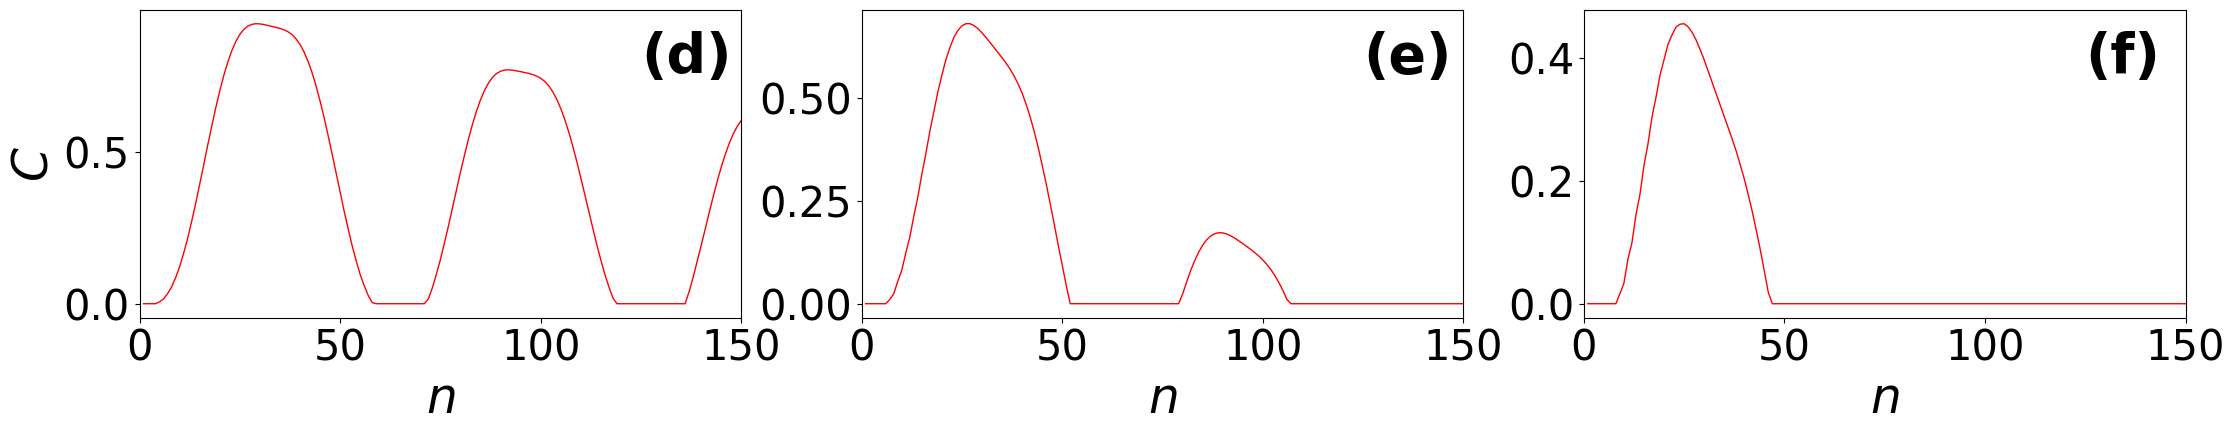

In [58]:
number =   109     #244

hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,3,figsize=(26.4, 4))

#plt.rcParams["text.usetex"] =True

p = axes[0].plot(times, Concur_1[number], 'r', linewidth=1.0)

axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$C$', fontsize=35, rotation=90, **hfont)

axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

p = axes[1].plot(times, Concur_2[number], 'r', linewidth=1.0)

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[1].set_ylabel(r'$C$', fontsize=25, **hfont)

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

p = axes[2].plot(times, Concur_3[number], 'r', linewidth=1.0)

axes[2].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[2].set_ylabel(r'$С$', fontsize=25, **hfont)

axes[2].tick_params(axis='x', labelsize=30)
axes[2].tick_params(axis='y', labelsize=30)

matplotlib.pyplot.text(-235, 0.4, '(d)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( -55, 0.4, '(e)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( 125, 0.4, '(f)', fontsize=40, weight="black",  verticalalignment='center')

axes[0].set_xticks(np.round(np.linspace(0, 150, 4), 2))
axes[0].set_xlim(0.0,150)
axes[1].set_xlim(0.0,150)
axes[2].set_xlim(0.0,150)

#plt.gcf().set_size_inches(26.5, 4)
#plt.savefig("C:/Users/Kirill Shulga/Desktop/Time-Molecule/TM_Pic1def.pdf", bbox_inches="tight")

#axes[1].set_xlim((0.475, 0.525))

Spectral gap calculation

In [26]:
nSites = 2 

eps_steps = 500
eps=np.linspace(0.00, 0.5, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                     #disorder
delta = [0,0]
g = 0.05*np.pi                               #Interaction
T = 1  

In [30]:
g1 = 0.01        # relaxation rate
g2 = 0.0025        # dephasing rate
n_th = 0.28       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(), identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2), sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [31]:
Spectral_gap = []
Eigen_Values = []
Super_Matrix = []

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    evals, evecs = la.eig(U)
    Super_Matrix.append(U)
    Spectral_gap.append(1/(-log(sort(abs(evals)))[-2]))
    Eigen_Values.append(evals)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 379.43it/s]


Text(0, 0.5, '$t_{eq}$')

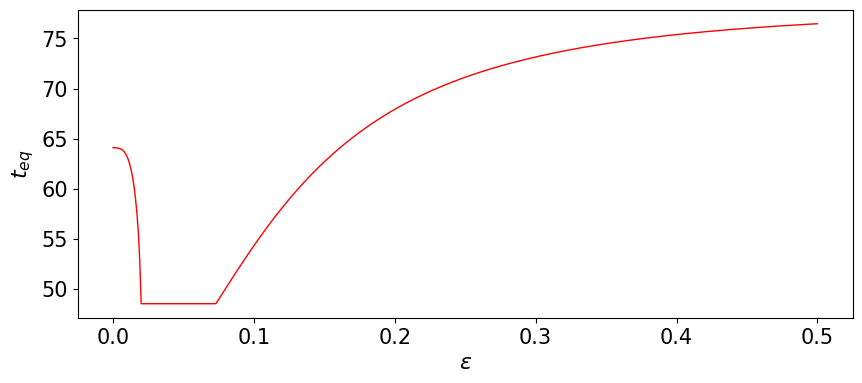

In [32]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 4))

p = axes.plot(eps, Spectral_gap, 'r', linewidth=1.0)

axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [35]:
eps_steps = 500
eps=np.linspace(0.00, 0.5, eps_steps)        #unperfection of pulses

In [36]:
def equlibrium_time_calc(g, n_th, g1, g2):
    nSites = 2 
    eps_steps = 500
    eps=np.linspace(0.00, 0.4, eps_steps)        #unperfection of pulses
    alpha = np.pi/2-eps
    w = 0.00                                     #disorder
    delta = [0,0]
    #g = 0.05*np.pi                               #Interaction
    T = 1  
    
    #g1 = 0.01        # relaxation rate
    #g2 = 0.0025        # dephasing rate
    #n_th = 0.08       # bath temperature
    
    c_ops = []
    # qubit 1 collapse operators
    sm1 = kron(sigma_minus(),identity_matrix(2))
    sz1 = kron(PauliMatrix(3), identity_matrix(2))
    c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
    c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
    c_ops.append(np.sqrt(g2) * sz1)

    # qubit 2 collapse operators
    sm2 = kron(identity_matrix(2),sigma_minus())  
    sz2 = kron(identity_matrix(2), PauliMatrix(3))
    c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
    c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
    c_ops.append(np.sqrt(g2) * sz2)
    
    Spectral_gap = []
    Eigen_Values = []
    Super_Matrix = []

    sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
    for i in range(2, nSites+1,1):
        sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
        U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
        evals, evecs = la.eig(U)
        Super_Matrix.append(U)
        Spectral_gap.append(1/(-log(sort(abs(evals)))[-2]))
        Eigen_Values.append(evals)
        
    return Spectral_gap

In [47]:
Spec0 = equlibrium_time_calc(0.05*0,  0.0, 0.01, 0.0025)
Spec1 = equlibrium_time_calc(0.05*0,  0.1, 0.01, 0.0025)
Spec2 = equlibrium_time_calc(0.05*0,  0.2, 0.01, 0.0025)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 349.45it/s]


Text(0, 0.5, '$t_{eq}$')

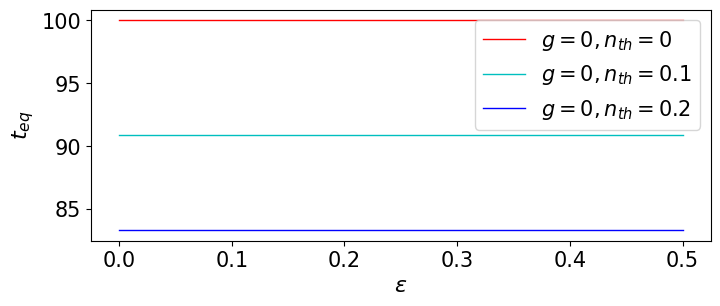

In [49]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$g = 0, n_{th} = 0$')
p = axes.plot(eps, Spec1,  'c', linewidth=1.0, label = '$g = 0, n_{th} = 0.1$')
p = axes.plot(eps, Spec2,  'b', linewidth=1.0, label = '$g = 0, n_{th} = 0.2$')

axes.legend()
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [37]:
Spec0 = equlibrium_time_calc(0.05*np.pi,  0.0, 0.01, 0.0025)
Spec8 = equlibrium_time_calc(0.05*np.pi,  0.1, 0.01, 0.0025)
Spec2 = equlibrium_time_calc(0.05*np.pi,  0.2, 0.01, 0.0025)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 386.23it/s]


Text(0, 0.5, '$t_{eq}$')

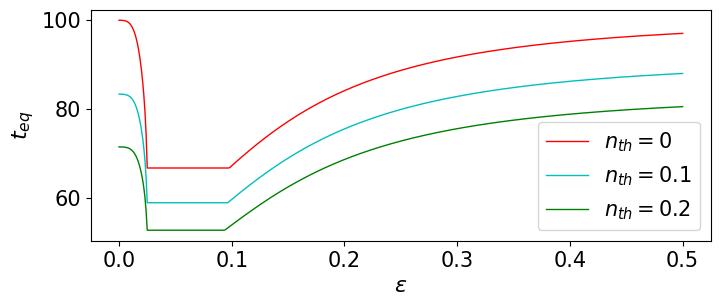

In [38]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$n_{th} = 0$')
p = axes.plot(eps, Spec8,  'c', linewidth=1.0, label = '$n_{th} = 0.1$')
p = axes.plot(eps, Spec2,  'g', linewidth=1.0, label = '$n_{th} = 0.2$')

axes.legend()
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

$n_{th}$

In [39]:
Spec0 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.005, 0.0025)
Spec8 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.0025)
Spec2 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.02, 0.0025)
Spec3 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.03, 0.0025)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 411.64it/s]


Text(0, 0.5, '$t_{eq}$')

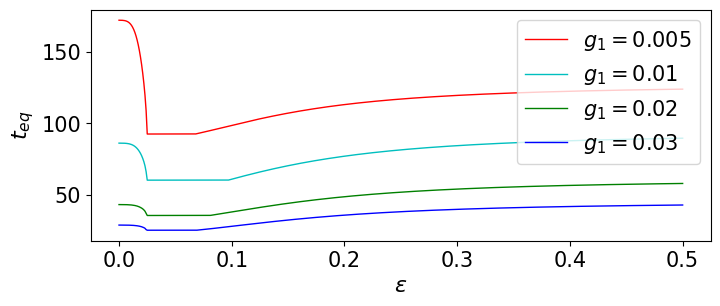

In [40]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$g_1 = 0.005$')
p = axes.plot(eps, Spec8,  'c', linewidth=1.0, label = '$g_1 = 0.01$')
p = axes.plot(eps, Spec2,  'g', linewidth=1.0, label = '$g_1 = 0.02$')
p = axes.plot(eps, Spec3,  'b', linewidth=1.0, label = '$g_1 = 0.03$')

axes.legend(loc="upper right")
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [41]:
Spec0 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.0005)
Spec8 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.0025)
Spec2 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.0050)
Spec3 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.01)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 381.10it/s]


Text(0, 0.5, '$t_{eq}$')

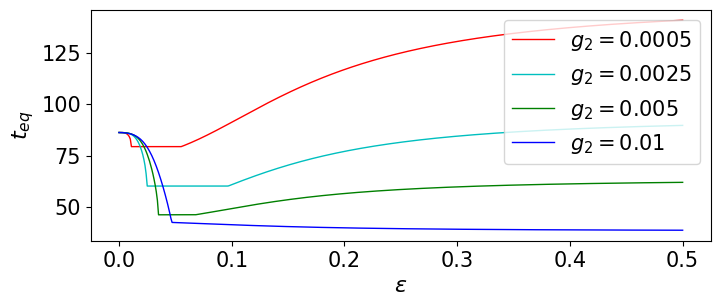

In [42]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$g_2 = 0.0005$')
p = axes.plot(eps, Spec8,  'c', linewidth=1.0, label = '$g_2 = 0.0025$')
p = axes.plot(eps, Spec2,  'g', linewidth=1.0, label = '$g_2 = 0.005$')
p = axes.plot(eps, Spec3,  'b', linewidth=1.0, label = '$g_2 = 0.01$')

axes.legend(loc="upper right")
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [35]:
Spec0 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.001, 0.0005)
Spec8 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.002, 0.001)
Spec2 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.005, 0.0025)
Spec3 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.005)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 345.18it/s]


Text(0, 0.5, '$t_{eq}$')

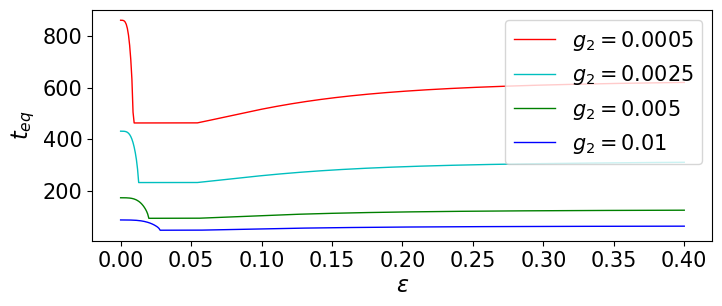

In [36]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$g_2 = 0.0005$')
p = axes.plot(eps, Spec8,  'c', linewidth=1.0, label = '$g_2 = 0.0025$')
p = axes.plot(eps, Spec2,  'g', linewidth=1.0, label = '$g_2 = 0.005$')
p = axes.plot(eps, Spec3,  'b', linewidth=1.0, label = '$g_2 = 0.01$')

axes.legend(loc="upper right")
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [108]:
Spec0 = equlibrium_time_calc(0.001*np.pi, 0.08)
Spec2 = equlibrium_time_calc(0.02*np.pi, 0.08)
Spec5 = equlibrium_time_calc(0.05*np.pi, 0.08)
Spec10 = equlibrium_time_calc(0.10*np.pi, 0.08)

  0%|                                                                                    | 0/500 [00:00<?, ?it/s]C:\Users\Cromat\AppData\Local\Temp\ipykernel_12784\1329641434.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  collapse = np.zeros((nSites**4,nSites**4), dtype=np.float)
100%|█████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 159.56it/s]


Text(0, 0.5, '$t_{eq}$')

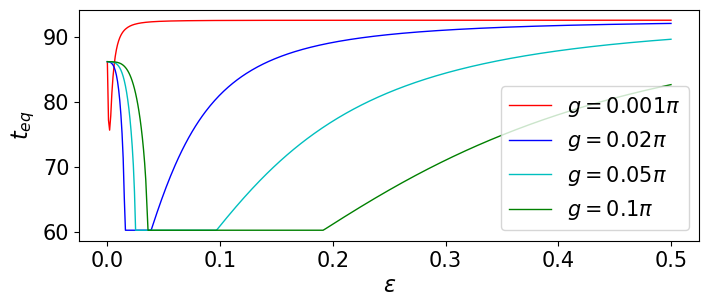

In [109]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$g = 0.001\pi$')
p = axes.plot(eps, Spec2,  'b', linewidth=1.0, label = '$g = 0.02\pi$')
p = axes.plot(eps, Spec5,  'c', linewidth=1.0, label = '$g = 0.05\pi$')
p = axes.plot(eps, Spec10, 'g', linewidth=1.0, label = '$g = 0.1\pi$')

axes.legend()
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

Text(0, 0.5, '$t_{eq}$')

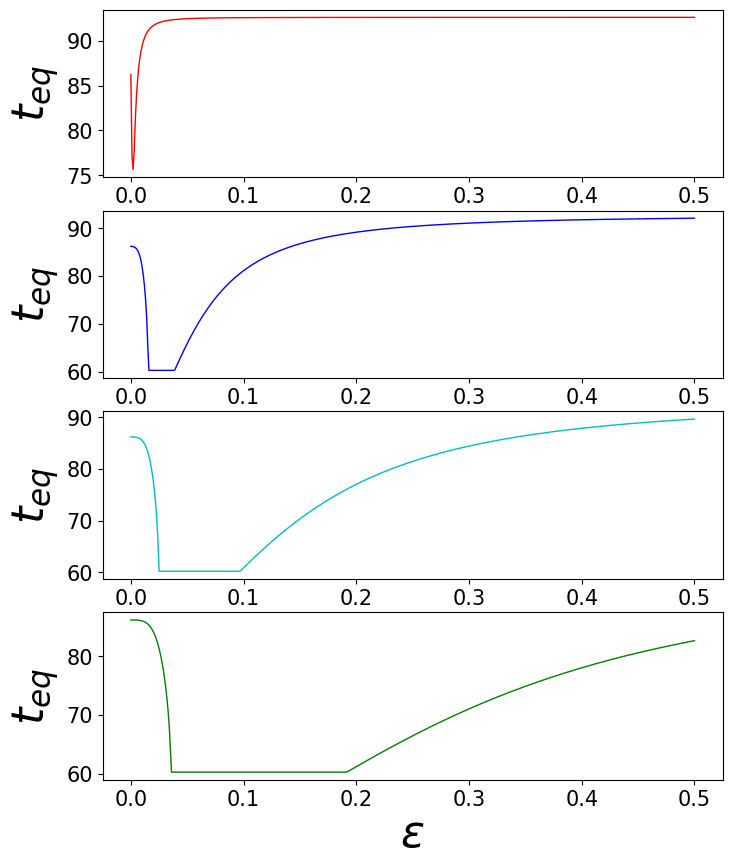

In [116]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(4,1,figsize=(8, 10))

p = axes[0].plot(eps, Spec0,  'r', linewidth=1.0, label = '$g = 0.001\pi$')
p = axes[1].plot(eps, Spec2,  'b', linewidth=1.0, label = '$g = 0.02\pi$')
p = axes[2].plot(eps, Spec5,  'c', linewidth=1.0, label = '$g = 0.05\pi$')
p = axes[3].plot(eps, Spec10, 'g', linewidth=1.0, label = '$g = 0.1\pi$')

#axes.legend()
axes[3].set_xlabel(r'$\epsilon$', fontsize=32, **hfont)
axes[0].set_ylabel(r'$t_{eq}$', fontsize=32, **hfont)
axes[1].set_ylabel(r'$t_{eq}$', fontsize=32, **hfont)
axes[2].set_ylabel(r'$t_{eq}$', fontsize=32, **hfont)
axes[3].set_ylabel(r'$t_{eq}$', fontsize=32, **hfont)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

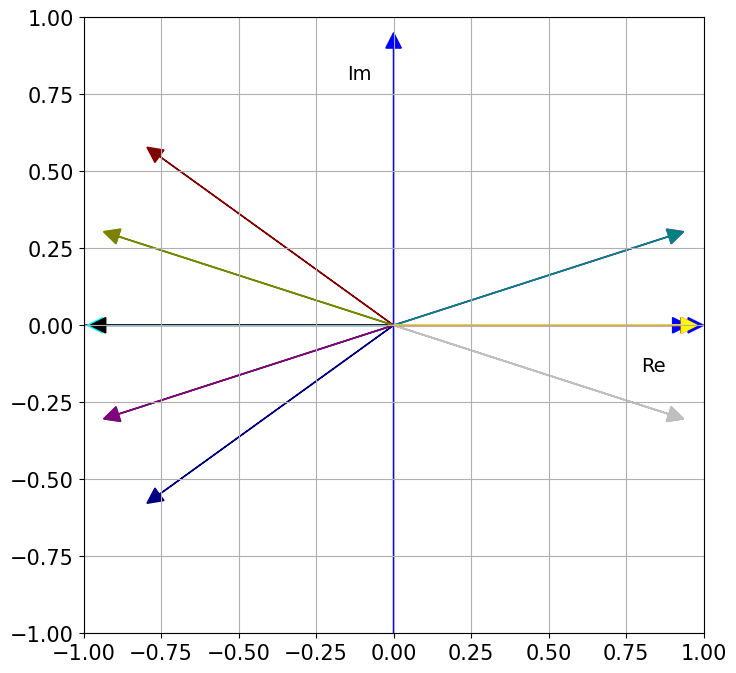

In [39]:
complex_plane2(Eigen_Values[1],1)

In [35]:
n = arange(eps_steps)
hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(1,1,figsize=(8, 8))

def update(n): 
    complex_plane2(Eigen_Values[n], 1, fig=fig, ax=ax)

anim = animation.FuncAnimation(fig, update, frames=eps_steps)

anim.save('C:/notebooks/animations/Complex_plane_ eigenvalues_TM2.mp4', writer=mywriter)

plt.close(fig)

In [36]:
display_embedded_video("C:/notebooks/animations/Complex_plane_ eigenvalues_TM2.mp4")

Evolution (Superoperator) density matrix visualization

In [37]:
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in matrix_chop(Super_Matrix[1])]))

   0   0   0   0   0(0.011-0j)   0   0   0   0(0.011+0j)   0   0   0   0(0.998+0j)
   0   0   0   0(0.01+0j)   0   0   0   0   0   0   0   0(-0-0.305j)(0.94+0j)   0
   0   0   0   0   0   0   0   0(0.01+0j)   0   0   0   0(0.94+0j)(-0-0.305j)   0
   0   0   0   0   0   0   0   0   0   0   0   0(0.979+0j)   0   0   0
   0(0.01-0j)   0   0   0   0   0(-0+0.305j)   0   0   0(0.94-0j)   0   0   0   0
(0.011-0j)   0   0   0   0(0.094+0j)(-0+0.289j)   0   0(-0-0.289j)(0.894-0j)   0   0   0   0   0
   0   0   0   0   0(-0+0.289j)(0.094-0j)   0   0(0.885+0j)(-0-0.289j)   0   0   0   0   0
   0   0   0   0(-0+0.302j)   0   0   0(0.931-0j)   0   0   0   0   0   0   0
   0   0(0.01-0j)   0   0   0   0(0.94-0j)   0   0   0(-0+0.305j)   0   0   0   0
   0   0   0   0   0(-0-0.289j)(0.885-0j)   0   0(0.094+0j)(-0+0.289j)   0   0   0   0   0
(0.011-0j)   0   0   0   0(0.894+0j)(-0-0.289j)   0   0(-0+0.289j)(0.094-0j)   0   0   0   0   0
   0   0   0   0(0.931-0j)   0   0   0(-0+0.302j)   0   0   0   

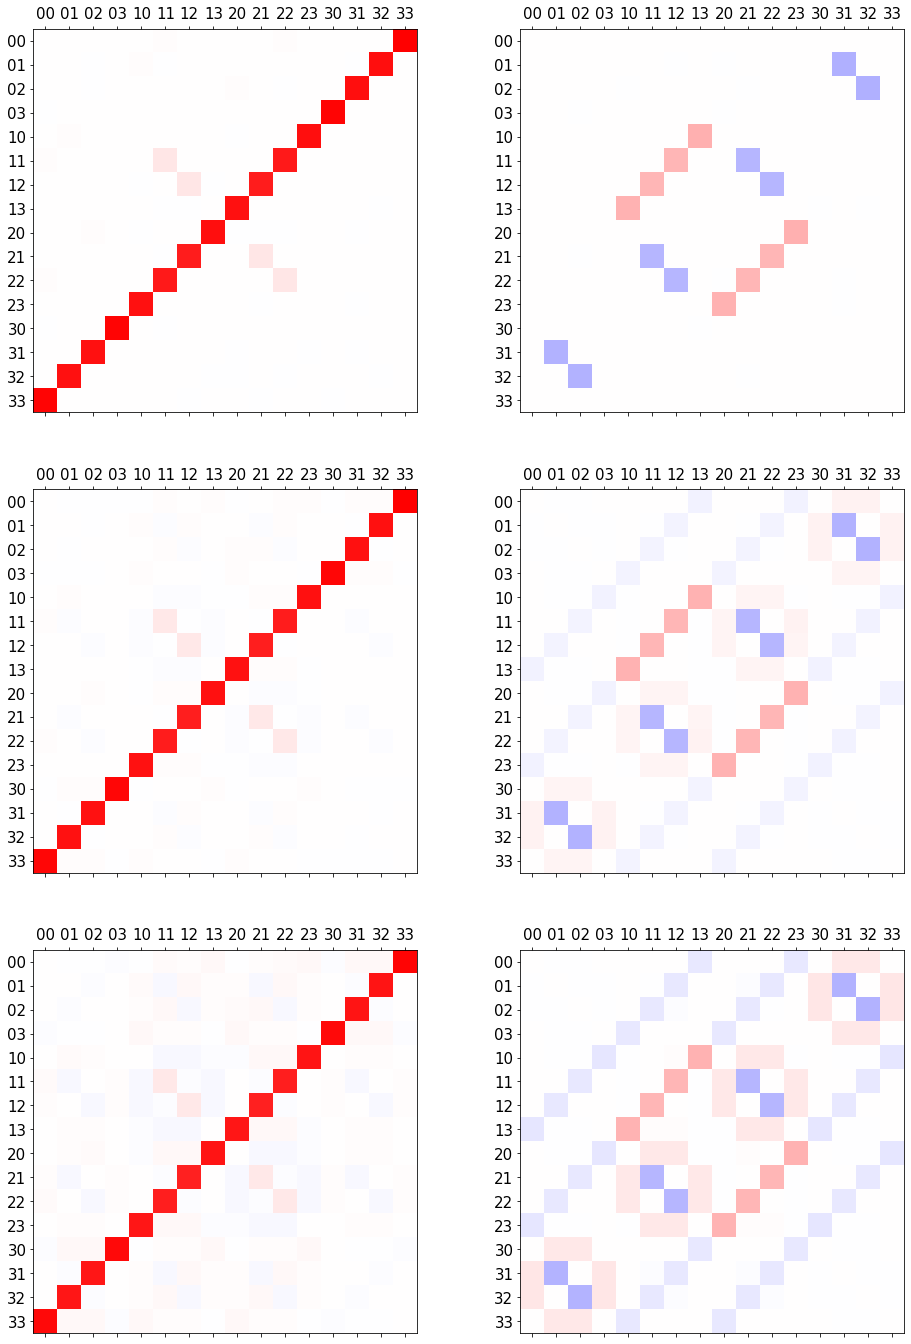

In [38]:
names = ['00', '01', '02', '03','10', '11', '12', '13', '20', '21', '22', '23','30', '31', '32', '33']
compare = [0,50,100]   


hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(3,2,figsize=(16, 24))
fig.canvas.draw()
    
cax = ax[0,0].matshow(real_imagination(Super_Matrix[compare[0]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[0,1].matshow(real_imagination(Super_Matrix[compare[0]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
#print (Super_Matrix[compare[0]])
cax = ax[1,0].matshow(real_imagination(Super_Matrix[compare[1]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[1,1].matshow(real_imagination(Super_Matrix[compare[1]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
#print (Super_Matrix[compare[1]])
cax = ax[2,0].matshow(real_imagination(Super_Matrix[compare[2]])[0], vmin=-1, vmax=1, cmap=cm.bwr)
cax = ax[2,1].matshow(real_imagination(Super_Matrix[compare[2]])[1], vmin=-1, vmax=1, cmap=cm.bwr)
#print (Super_Matrix[compare[2]])



for i in arange(3):
    for j in arange(2):
        ax[i,j].set_yticks(np.round(np.linspace(0, 15, 16), 1))
        ax[i,j].set_xticks(np.round(np.linspace(0, 15, 16), 1))
        labelsx = [item.get_text() for item in ax[i,j].get_xticklabels()]
        labelsy = [item.get_text() for item in ax[i,j].get_yticklabels()]
        for namae_id, namae_value in enumerate(names):
            labelsx[namae_id] = namae_value
            labelsy[namae_id] = namae_value
        ax[i,j].set_xticklabels(labelsx)
        ax[i,j].set_yticklabels(labelsy)
        
#plt.gcf().set_size_inches(16,24)
#plt.savefig("C:/neon/Superoperator_density_matrix(down,constant and up phases).pdf", bbox_inches="tight")

Spectrap gap for the different interactions

In [44]:
nSites = 2 

eps_steps = 5000
eps=np.linspace(0.0, 0.2, eps_steps)        #unperfection of pulses
eps=np.linspace(-5*np.pi/2, 5*np.pi/2, eps_steps)        #unperfection of pulses
#eps=np.linspace(np.pi/2-0.1, np.pi/2+0.1, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = [0,0]
T = 1  
g_steps = 5000
g = np.linspace(0.0, 10*np.pi/2, g_steps)                                 #Interaction
#g = np.linspace(0.785*np.pi, 0.835*np.pi, g_steps)                    #Interaction

In [45]:
g1 = 0.01        # relaxation rate
g2 = 0.005        # dephasing rate
#g2 = g1/sqrt(2)/2   # dephasing rate

n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [46]:
Spectral_gap = np.zeros((eps_steps,g_steps), dtype=float)

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
    spec_gap = []
    for g_id, g_value in enumerate(g): 
        U=Ufunc_all_to_all_lind(nSites,alpha_value,g_value,T,delta,c_ops)
        evals, evecs = la.eig(U)
        spec_gap.append(1/(-log(sort(abs(evals)))[-2]))
    Spectral_gap[alpha_id] = spec_gap

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [18:27:13<00:00, 13.29s/it]


In [88]:
#np.savetxt("bigmatrix1.txt",Spectral_gap,delimiter=',');

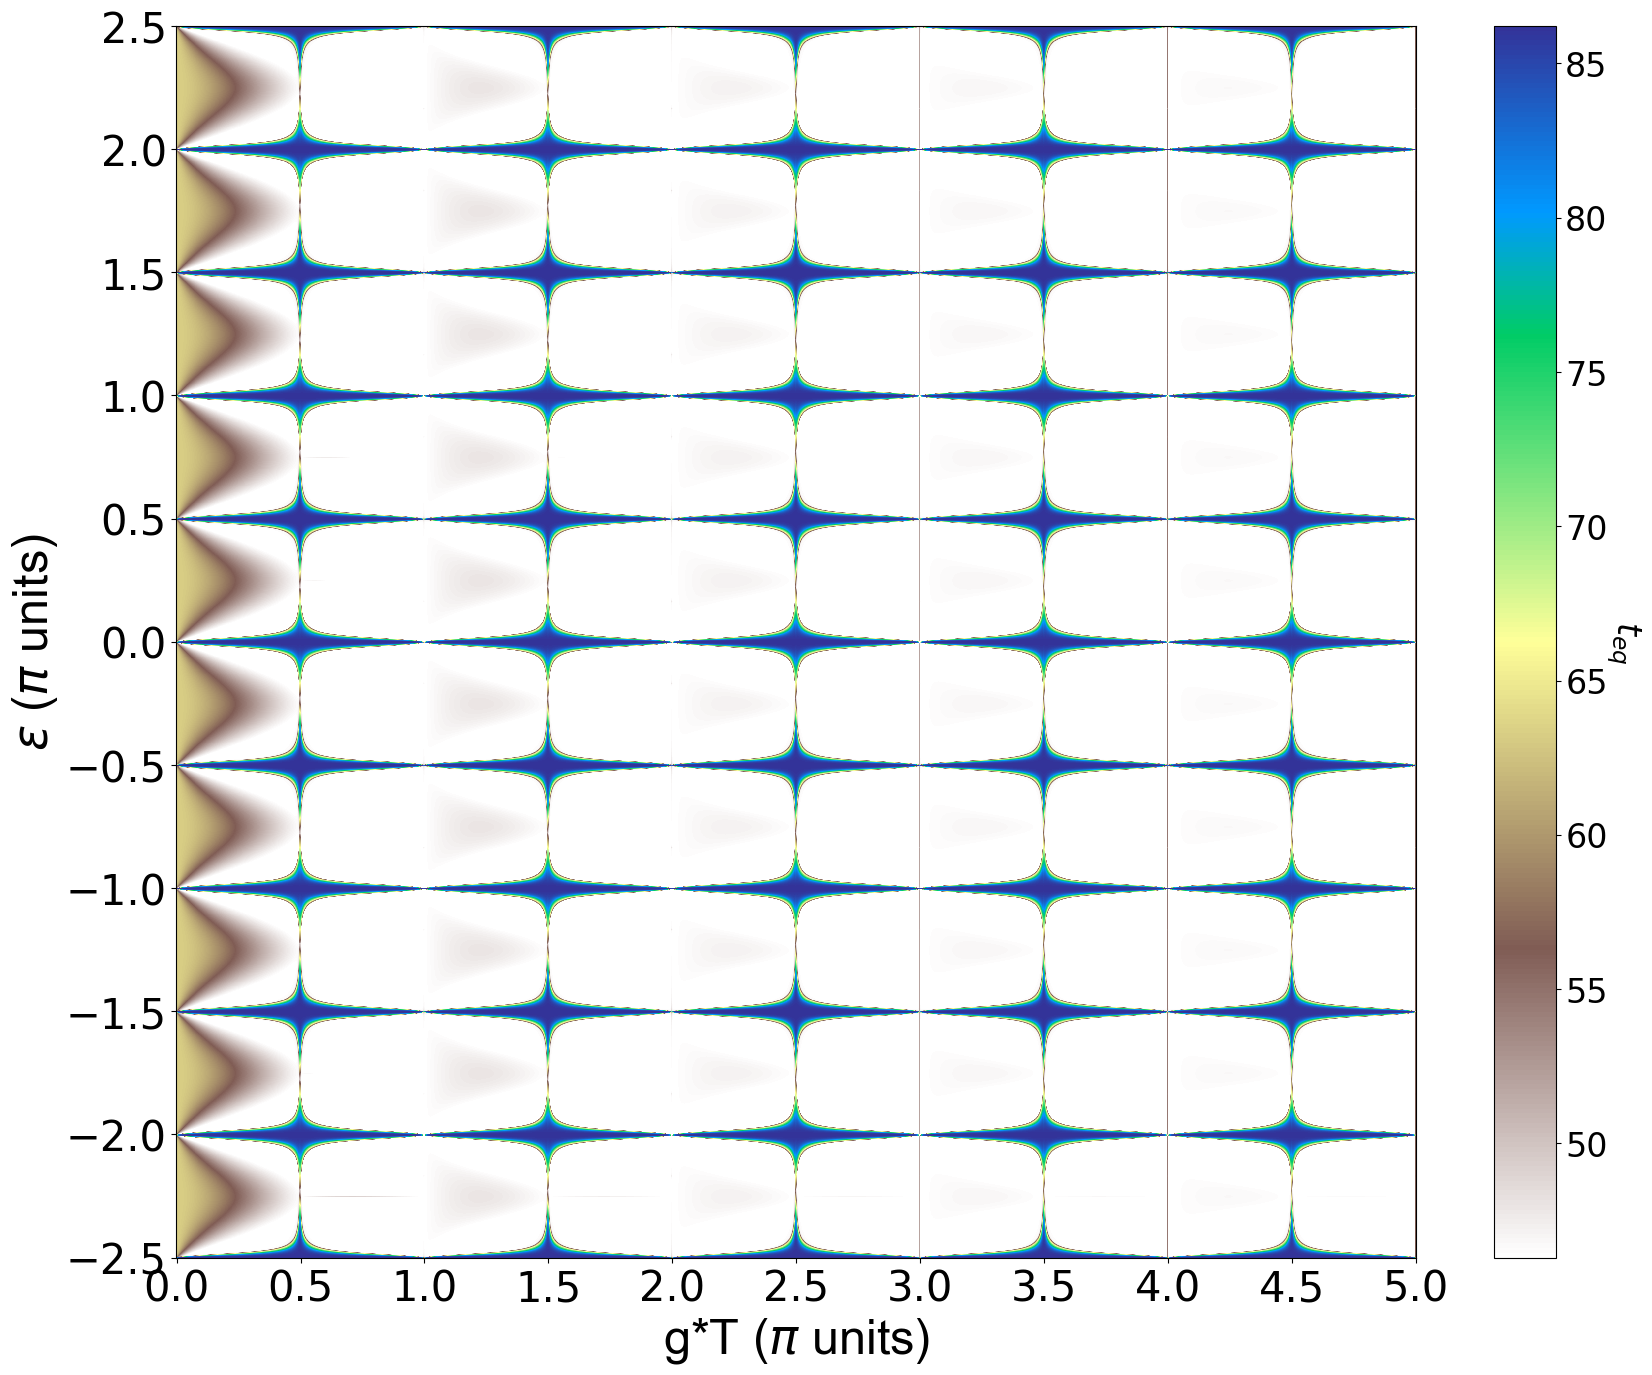

In [51]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(20, 16))

p = axes.pcolor(g/np.pi, eps/np.pi, Spectral_gap, shading='nearest', cmap=cm.terrain_r)

axes.axis('tight')
axes.set_xlabel(r'g*T ($\pi$ units)', fontsize=35, **hfont)
axes.set_ylabel(r'$\epsilon$ ($\pi$ units)', fontsize=35, **hfont)

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$t_{eq}$', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=24) 
    
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 11), 2))

xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 11), 2))

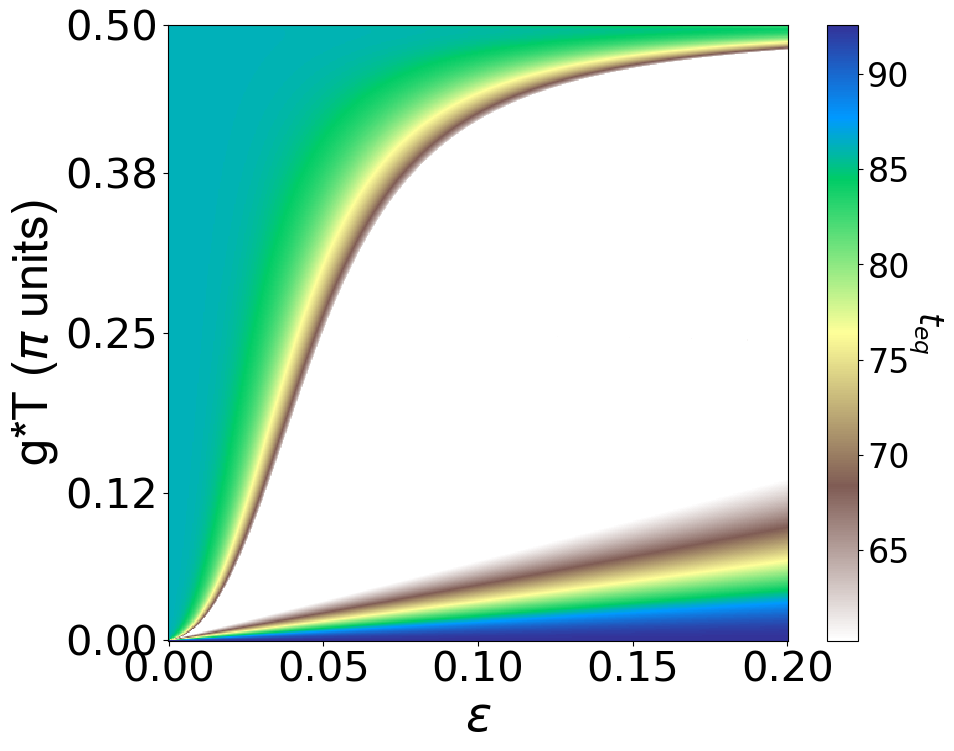

In [56]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 8))

p = axes.pcolor(eps,  g/np.pi, Spectral_gap.T, shading='nearest', cmap=cm.terrain_r)

axes.axis('tight')
axes.set_ylabel(r'g*T ($\pi$ units)', fontsize=35, **hfont)
axes.set_xlabel(r'$\epsilon$', fontsize=35, **hfont)

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$t_{eq}$', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=24) 
    
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 5), 2))

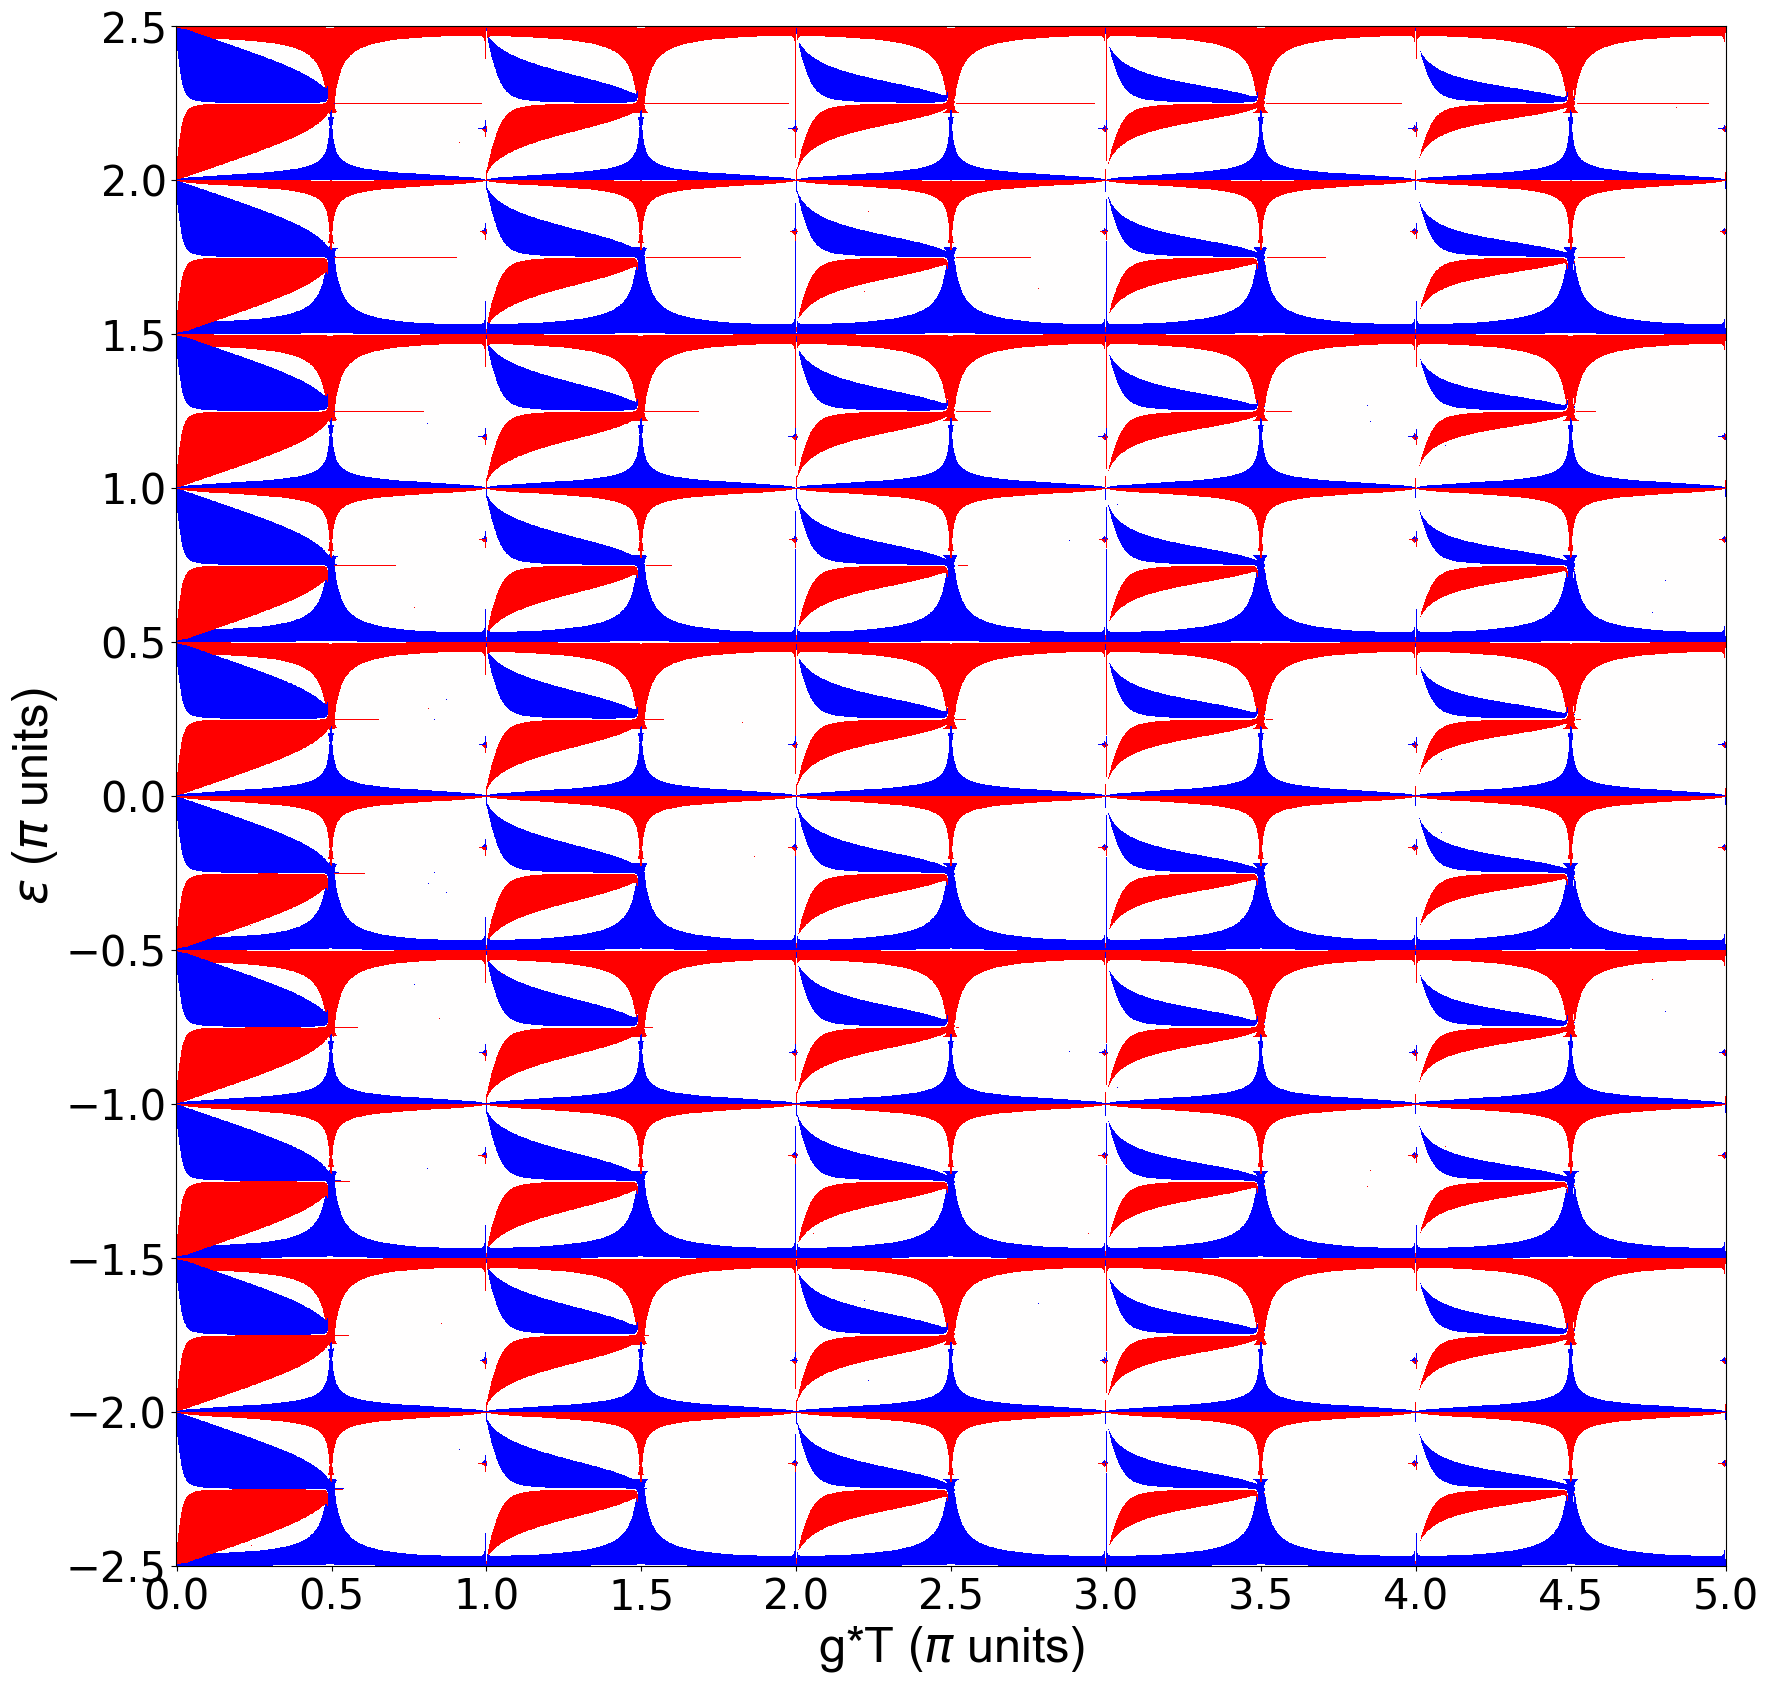

In [50]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(20, 20))

p = axes.pcolor(g/np.pi, eps/np.pi, Piecewisese(Spectral_gap), shading='nearest', cmap=cm.bwr)

axes.axis('tight')
axes.set_xlabel(r'g*T ($\pi$ units)', fontsize=35, **hfont)
axes.set_ylabel(r'$\epsilon$ ($\pi$ units)', fontsize=35, **hfont)

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)
    
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 11), 2))
xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 11), 2))

#plt.gcf().set_size_inches(20,30)
#plt.savefig("C:/neon/Phases2.pdf", bbox_inches="tight")

In [35]:
new_matrix = Piecewisese(Spectral_gap)

C:\Users\Cromat\AppData\Local\Temp\ipykernel_14744\1237684749.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  New = np.zeros((eps_steps,g_steps), dtype=np.float)


Artifact pieces tracking

In [40]:
track = []

for i in arange(eps_steps):
    if np.where(new_matrix[i] == -1)[0].size:
        track.append(np.where(new_matrix[i] == -1)[0][0])
    else:
        track.append(0)      

In [41]:
lengths = np.zeros(eps_steps)
j=0
for i in arange(size(track)):
    if track[i]!=0:
        lengths[j]=lengths[j]+1
        if track[i+1] == 0:
            j=j+1   

IndexError: list index out of range

In [42]:
lengths[lengths != 0]

array([268.,   1.,   2.])

Text(0, 0.5, 'Artifact position')

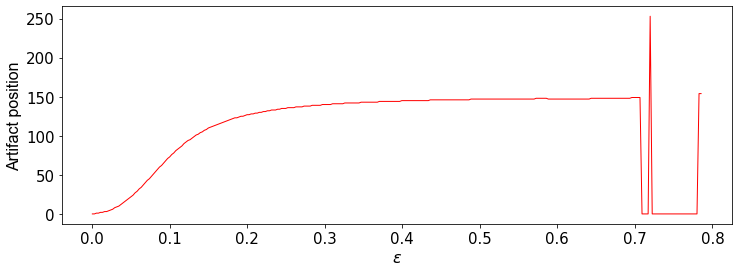

In [43]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(12, 4))

p = axes.plot(eps, track, 'r', linewidth=1.0)

axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'Artifact position', fontsize=16, **hfont)

Text(0, 0.5, 'Step length')

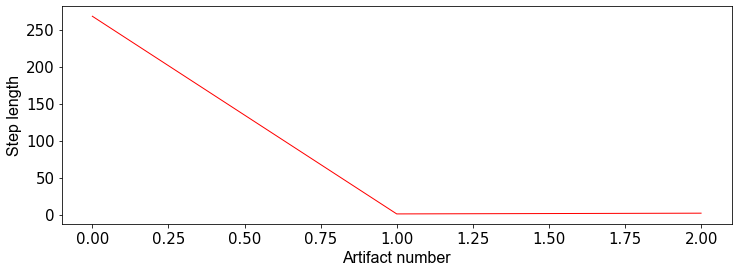

In [44]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(12, 4))

p = axes.plot(lengths[lengths != 0], 'r', linewidth=1.0)

axes.set_xlabel(r'Artifact number', fontsize=16, **hfont)
axes.set_ylabel(r'Step length', fontsize=16, **hfont)

# Animation

In [253]:
nSites = 2 

eps_steps = 500
eps=np.linspace(0.00, 1.0, eps_steps)        #unperfection of pulses
eps=np.linspace(0.5, 0.8, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = [0,0]
T = 1  
g_steps = 500
g = np.linspace(0.0, np.pi, g_steps)                    #Interaction
g = np.linspace(0.785*np.pi, 0.835*np.pi, g_steps) 


g1 = 0.02        # relaxation rate
g2 = 0.01        # dephasing rate
n_th = 0.1       # bath temperature

##----------------------------------------------------
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
    
A_steps = 50
A = linspace(0, n_th, A_steps)

In [254]:
def plot_Time_Molecule(Temperature, fig=None, axes=None):
    Spectral_gap = np.zeros((eps_steps,g_steps), dtype=float)

    sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
    for i in range(2, nSites+1,1):
        sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    c_ops = []
    # qubit 1 collapse operators
    c_ops.append(np.sqrt(g1 * (1+Temperature)) * sm1)
    c_ops.append(np.sqrt(g1 * Temperature) * sm1.T.conj())
    c_ops.append(np.sqrt(g2) * sz1)

    # qubit 2 collapse operators
    c_ops.append(np.sqrt(g1 * (1+Temperature)) * sm2)
    c_ops.append(np.sqrt(g1 * Temperature) * sm2.T.conj())
    c_ops.append(np.sqrt(g2) * sz2)        
    
    for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
        spec_gap = []
        for g_id, g_value in enumerate(g): 
            U=Ufunc_all_to_all_lind(nSites,alpha_value,g_value,T,delta,c_ops)
            evals, evecs = la.eig(U)
            spec_gap.append(1/(-log(sort(abs(evals)))[-2]))
        Spectral_gap[alpha_id] = spec_gap
    hfont = {'fontname':'Arial'}
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(1, 1, figsize=(8,8))
    
    p = axes.pcolor(g/np.pi, eps, Piecewisese(Spectral_gap), cmap=cm.bwr)

    axes.axis('tight')
    axes.set_xlabel(r'g*T ($\pi$ units)', fontsize=35, **hfont)
    axes.set_ylabel(r'$\epsilon$', fontsize=35, **hfont)

    axes.tick_params(axis='x', labelsize=30)
    axes.tick_params(axis='y', labelsize=30)
    
    ymin, ymax = axes.get_ylim()
    axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
    xmin, xmax = axes.get_xlim()
    axes.set_xticks(np.round(np.linspace(xmin, xmax, 5), 2))
    
    return fig, axes

In [255]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 8))

def update(n): 
    plot_Time_Molecule(A[n], fig=fig, axes=axes)

anim = animation.FuncAnimation(fig, update, frames=A_steps)

anim.save('C:/notebooks/animations/Phases_6.mp4', writer=mywriter)

plt.close(fig)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [23:52<00:00,  2.86s/it]


In [256]:
display_embedded_video("C:/notebooks/animations/Phases_6.mp4")

In [218]:
def real_imagination(matrix):
    new_re = np.zeros((size(matrix[0]),size(matrix[0])), dtype=float)
    new_im = np.zeros((size(matrix[0]),size(matrix[0])), dtype=float)
    full = np.zeros((size(matrix[0]),size(matrix[0])), dtype=np.complex)
    for i in arange(size(matrix[0])):
        for j in arange(size(matrix[0])):
            new_re[i][j] = matrix[i][j].real
            new_im[i][j] = matrix[i][j].imag
            full[i][j] = matrix[i][j].real+matrix[i][j].imag*1j
    return new_re, new_im, full    

In [219]:
line = 200
period = 31

print(Observables[line][period])
print(RHO[line][period])

0.4613224561105737
[[(0.43279598299314526-7.979727989493313e-17j)
  (0.2546538715203785+0.071973170444086j)
  (0.25465387152037827+0.07197317044408683j)
  (-0.16364266764149446-0.2243435462320621j)]
 [(0.2546538715203772-0.07197317044408613j)
  (0.1825346310345052+3.0227556568895864e-16j)
  (0.16364266764149457+1.5720931501039814e-17j)
  (-0.14120404771600772-0.10606988535764418j)]
 [(0.2546538715203791-0.07197317044408633j)
  (0.1636426676414952+1.1449174941446927e-16j)
  (0.1825346310345047+1.700029006457271e-16j)
  (-0.14120404771600942-0.10606988535764422j)]
 [(-0.16364266764149563+0.22434354623206162j)
  (-0.14120404771600825+0.1060698853576432j)
  (-0.14120404771600892+0.10606988535764383j)
  (0.2021347549378584+1.7520707107365752e-16j)]]


In [220]:
Test = RHO[line][period]

In [221]:
matrix_chop(real_imagination(Test)[0])

[[0.433, 0.255, 0.255, -0.164],
 [0.255, 0.183, 0.164, -0.141],
 [0.255, 0.164, 0.183, -0.141],
 [-0.164, -0.141, -0.141, 0.202]]

In [222]:
matrix_chop(real_imagination(Test)[1])

[[0, 0.072, 0.072, -0.224],
 [-0.072, 0, 0, -0.106],
 [-0.072, 0, 0, -0.106],
 [0.224, 0.106, 0.106, 0]]

In [223]:
matrix_chop(real_imagination(Test)[2])

[[(0.433-0j), (0.255+0.072j), (0.255+0.072j), (-0.164-0.224j)],
 [(0.255-0.072j), (0.183+0j), (0.164+0j), (-0.141-0.106j)],
 [(0.255-0.072j), (0.164+0j), (0.183+0j), (-0.141-0.106j)],
 [(-0.164+0.224j), (-0.141+0.106j), (-0.141+0.106j), (0.202+0j)]]

In [224]:
Test=matrix_chop(real_imagination(Test)[2])

In [225]:
evals, evecs = la.eig(Test)
Fl_vec = evecs.T
print(chop(real(-1j*log(evals))))
print(matrix_chop(Fl_vec))

[0, 0, 0, 0]
[[(0.668+0j), (0.405-0.116j), (0.405-0.116j), (-0.265+0.357j)], [(0.532+0j), (-0.49-0.112j), (-0.49-0.112j), (-0.39-0.246j)], [(0.501+0.141j), (-0.09+0.248j), (-0.09+0.248j), (0.768+0j)], [0, (0.707+0j), (-0.707+0j), 0]]


What would happend if the initial state will be one of the eigenstate of the system?

In [25]:
Observables = np.zeros((4,eps_steps,time_steps), dtype=float)

f = IntProgress(min=0, max=eps_steps*4) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for j in arange(4):
    for alpha_id, alpha_value in enumerate(alpha): 
    
        U=Ufunc_all_to_all(nSites,alpha_value,g,T,delta)

        evals, evecs = la.eig(U)
        Fl_vec = evecs.T                # initial state is the eigen state for nondissipative case

        U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
        initialState = Fl_vec[j]
        initialStateDensityMatrix = fullDensityMatrixToflat(kron(initialState.conj(),initialState))


        Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states
    
        Temp = []
        for i in arange(time_steps):
            Temp.append(flatDensityMatrixToFull(Final[i]))
        Final = Temp

        observables = []
      
        for i in Final:
            observables.append(np.dot(sigZOp,i).trace())
    
        f.value += 1
        Observables[j][alpha_id] = observables 

A Jupyter Widget

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


In [41]:
print (chop(Fl_vec[1]))

[(0.529+0j), (0.469+0.023j), (0.469+0.023j), (0.529-0j)]


Strange evolution depending on the chosen eigenstate to start with

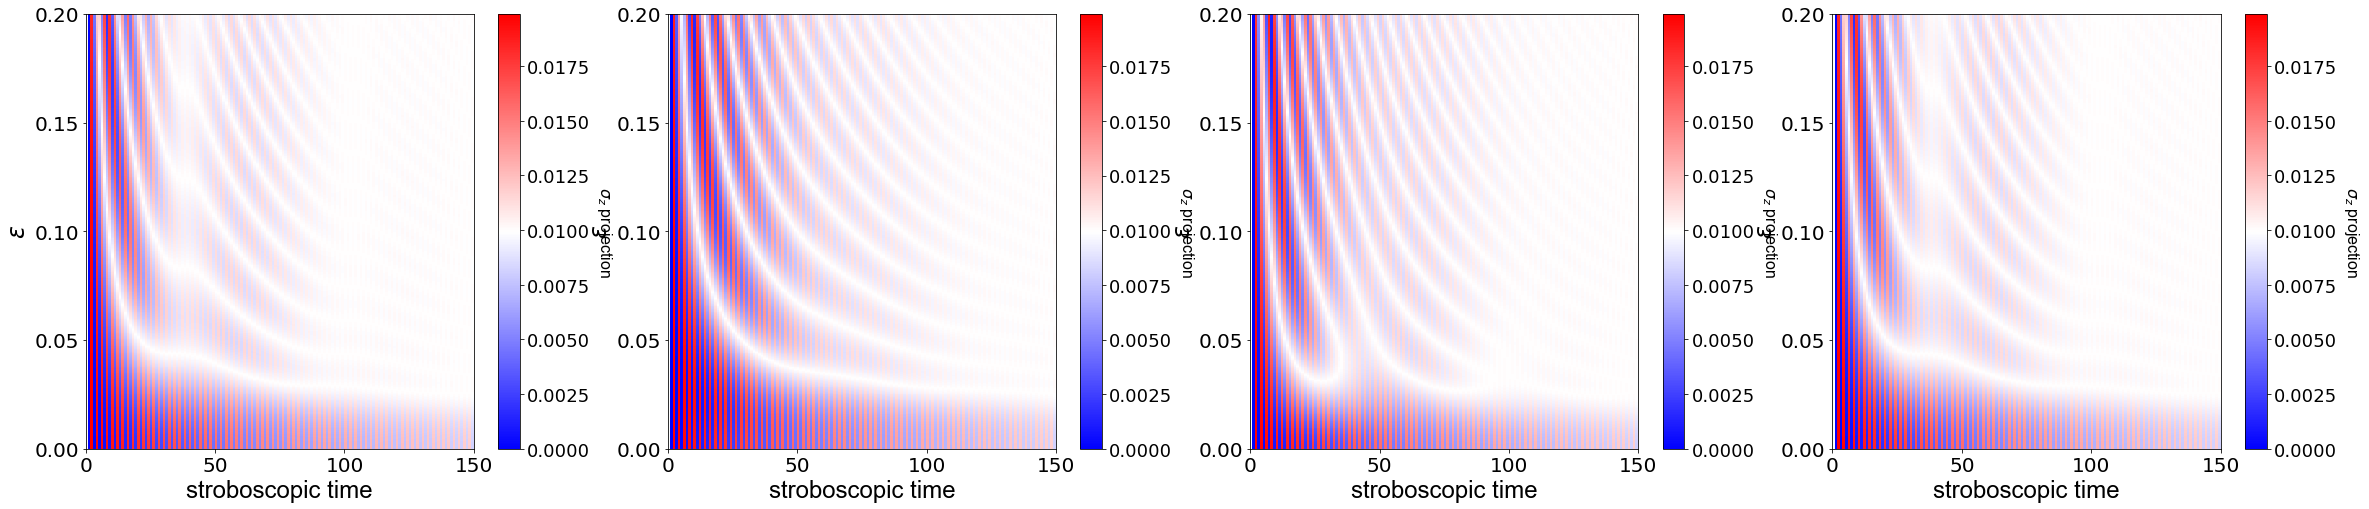

In [375]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,4,figsize=(40, 8))

for i in arange(4):
    p = axes[i].pcolor(times, eps, Observables[i], cmap=cm.bwr)

    axes[i].axis('tight')
    axes[i].set_xlabel(r'stroboscopic time', fontsize=24, **hfont)
    axes[i].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)

    cb = fig.colorbar(p, ax=axes[i])
    cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=16, **hfont)
    cb.ax.tick_params(labelsize=18) 
    
    ymin, ymax = axes[i].get_ylim()
    axes[i].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
    xmin, xmax = axes[i].get_xlim()
    axes[i].set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

# offdiagonal term analizys

here I am looking for the offdiagonal terms of the density matrix

In [43]:
nSpins = 2
nSites = nSpins
eps=0.2               #unperfection of pulses
#0.0436

alpha = np.pi/2-eps
w = 0.0                   #disorder
delta = [0,0]
#delta = deltaS(w, nSpins)
T = 1                     # Period
##----------------------------------------------------
timess=200
times = np.linspace(1, timess, timess)
##----------------------------------------------------

In [44]:
g1 = 0.00        # relaxation rate
g2 = 0.01        # dephasing rate
n_th = 0.1       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [45]:
coupling1 = 0.00                  #Interaction without pumping
coupling2 = 0.1                   #Interaction with pumping

U=Ufunc_all_to_all(nSites,alpha,coupling2,T,delta)

evals, evecs = la.eig(U)
Fl_vec = evecs.T
initialState = Fl_vec
#print(chop(initialState))
initialStateDensityMatrix = []
for i in arange(4):
    initialStateDensityMatrix.append(fullDensityMatrixToflat(kron(initialState[i].conj(),initialState[i])))

U1=Ufunc_all_to_all_lind(nSpins,0,coupling1,T, delta,c_ops)
U2=Ufunc_all_to_all_lind(nSpins,alpha,coupling2,T, delta,c_ops)


# Evolution

C:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


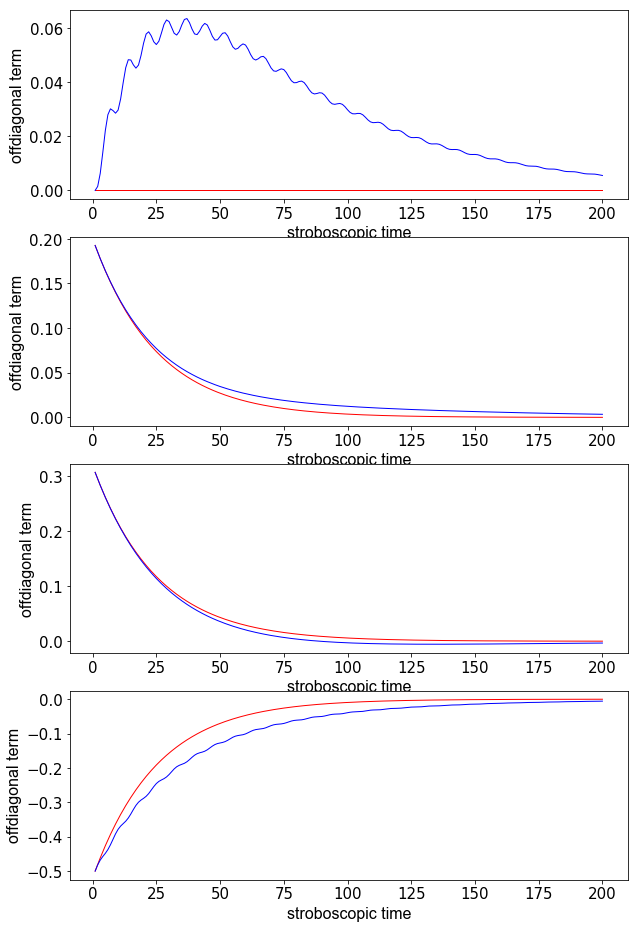

In [47]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(4,1,figsize=(10, 16))

for i in arange(4):
    #Just applying it several times
    evolvedStates1 = states_lind(initialStateDensityMatrix[i],U1,timess)
    evolvedStates2 = states_lind(initialStateDensityMatrix[i],U2,timess)

    #Reconstructing density matrix from vectorized forms
    Temp1 = []
    Entropy1 = []
    Temp2 = []
    Entropy2 = []

    for k in arange(timess):
        Temp1.append(flatDensityMatrixToFull(evolvedStates1[k]))
        Entropy1.append(Partial_Entropy_2(flatDensityMatrixToFull(evolvedStates1[k])))
        Temp2.append(flatDensityMatrixToFull(evolvedStates2[k]))
        Entropy2.append(Partial_Entropy_2(flatDensityMatrixToFull(evolvedStates2[k])))
    evolvedStates1 = Temp1
    evolvedStates2 = Temp2
    
    first = []
    second = []
    for j in arange(timess):
        first.append(evolvedStates1[j][2][1])     # looking for the [2][1] term  of the density matrix evolution
        second.append(evolvedStates2[j][2][1])
        
    p = axes[i].plot(times, first, 'r', linewidth=1.0)
    p = axes[i].plot(times,second, 'b', linewidth=1.0)
    axes[i].set_xlabel(r'stroboscopic time', fontsize=16, **hfont)
    axes[i].set_ylabel(r'offdiagonal term', fontsize=16, **hfont)